In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import shutil
import getpass
import yaml

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

WANDB_ACTIVE = False
os.environ["WANDB_NOTEBOOK_NAME"] = "Autoencoder_dev.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import wandb
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace 

timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print('Timestamp: ',timestamp)
# logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
# FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
# logging.basicConfig(level="INFO", format= FORMAT)
# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y%m%d_%H%M%S'))

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
Timestamp:  2024_05_06_16:54:28


# Setup

In [3]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"
"""Sample module for using DNN classifier with SNNL"""

# import argparse
# import torch
# from pt_datasets import create_dataloader, load_dataset
# from pt_datasets import display_cellpainting_batch
# from snnl.models import DNN
from snnl.utils import parse_args, get_hyperparameters, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_train_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary

from dev_base import Model
from dev_dnn  import DNN 
from dev_autoencoder import Autoencoder
from dev_snnloss import SNNLoss

'Sample module for using DNN classifier with SNNL'

In [4]:
current_device = get_device()
print(f"Current device is : {current_device}")

 device: 0   Quadro GV100                   :  free: 31,706,382,336 B   (29.53 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 30,070,603,776 B   (28.01 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 2   NVIDIA TITAN Xp                :  free: 12,373,852,160 B   (11.52 GB)    total: 12,774,539,264 B   (11.90 GB)
 Current CUDA Device is: cuda:0 Quadro GV100 0
Current device is : cuda:0


### main(args)

In [5]:
# if __name__ == "__main__":
input_args = f" --seed              1234 " \
             f" --model             snnl" \
             f" --configuration      hyperparameters/autoencoder_cellpainting.yaml"
             # f" --configuration    hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())
args

with open(args.configuration) as f:
    args = types.SimpleNamespace(**yaml.safe_load(f), **(vars(args)))
args.batch_size = args.cellpainting_args['batch_size']
args.compounds_per_batch = args.cellpainting_args['compounds_per_batch']

# set_global_seed(args.seed)
# ## Autoencoder
# (   dataset,
#     batch_size,
#     epochs,
#     learning_rate,
#     input_shape,
#     code_units,
#     units,
#     activations,
#     snnl_factor,
#     temperature,
#     cellpainting_args
# ) = get_hyperparameters(args.configuration)

Namespace(seed=1234, model='snnl', configuration='hyperparameters/autoencoder_cellpainting.yaml')

In [6]:
trn_file_sz = args.cellpainting_args['train_end'] - args.cellpainting_args['train_start']
val_file_sz = args.cellpainting_args['val_end'] - args.cellpainting_args['val_start']
smp_sz = args.cellpainting_args['sample_size']
buf_sz = args.cellpainting_args['compounds_per_batch']
bth_sz = args.cellpainting_args['batch_size']
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [trn_file_sz, val_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 800
 - Rows covered by 800 full size batches (300 rows) per epoch:  240000
 - Last partial batch contains : 0 rows

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 80
 - Rows covered by 80 full size batches (300 rows) per epoch:  24000
 - Last partial batch contains : 0 rows



## Define dataset and dataloaders

In [7]:
#### Load CellPainting Dataset
if args.dataset == 'cellpainting':
    print(f" load {args.dataset}")
    train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
    train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
    val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    
# for idx, batch in enumerate(train_loader):
#     print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     display_cellpainting_batch(idx, batch)
#     if idx >= 0:
#         break

 load cellpainting
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    _init()_    -- type :             train
    _init()_    -- start :            0
    _init()_    -- end :              240000
    _init()_    -- numrows :          240000
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             val
    _init()_    -- start :            0
    _init()_    -- end :              24000
    _init()_    -- numrows :          24000


In [8]:
args.title = 'secondTry'
args.project_name = 'CellPainting_Profiles'
args.exp_id   = None
args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
args.exp_desc = 'Autoencoder Training in SNNL mode'+' - '+args.title
print(args.exp_name, args.exp_desc)

AE_0506_1654 Autoencoder Training in SNNL mode - secondTry


In [9]:
if WANDB_ACTIVE:
    wandb_run = init_wandb(args)

## Override arguments

In [13]:
show_every = 1
save_every = 25
args.temperature   = 10.00
args.loss_factor   = 4.0 ## 2.0e+00
args.snnl_factor   = 0.25 ## 1.0e+00
args.learning_rate = 1.0e-03    ## 0.001
args.temperatureLR = 1.0e-03    ## 1e-4
print(f"   Latent dim        {args.code_units}")
print(f"   loss_factor       {args.loss_factor}")
print(f"   snnl_factor       {args.snnl_factor}")
print(f"   temperature       {args.temperature}")
print(f"   learning_rate     {args.learning_rate}")
print(f"   temperatureLR:    {args.temperatureLR}")
type(args.learning_rate)

   Latent dim        50
   loss_factor       4.0
   snnl_factor       0.25
   temperature       10.0
   learning_rate     0.001
   temperatureLR:    0.001


float

In [14]:
list_namespace(args)


command line parms : 
-----------------------
activations..............  ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start................  0
    validation_path..........  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv

code_units...............  50
compounds_per_batch...

# Define autoencoder model

## Define Model

In [15]:
if args.model.lower() == "baseline":
    print(f"Defining model in baseline mode")
    model = Autoencoder(
        units=args.units,
        activations = args.activations,
        code_units  = args.code_units, 
        criterion   = torch.nn.MSELoss(reduction='mean'),
        input_shape = args.input_shape, 
        sample_size = args.cellpainting_args['sample_size'],
        loss_factor = args.loss_factor,
        snnl_factor=args.snnl_factor,
        learning_rate=args.learning_rate,
        embedding_layer = 4,
        use_scheduler = True
        )
elif args.model.lower() == "snnl":
    print(f"Defining model in SNNL mode ")
    model = Autoencoder(
        mode="latent_code",
        units=args.units,
        activations = args.activations,
        code_units = args.code_units,
        input_shape=args.input_shape,
        sample_size = args.cellpainting_args['sample_size'],
        criterion = torch.nn.MSELoss(reduction='mean'),
        loss_factor = args.loss_factor,
        learning_rate=args.learning_rate,
        use_snnl=True,
        snnl_factor=args.snnl_factor,
        temperature=args.temperature,
        use_annealing= False,        
        use_sum = False,
        temperatureLR=args.temperatureLR,
        adam_weight_decay = 0,
        SGD_weight_decay= 0,
        embedding_layer = 4,
        use_scheduler = True,
        use_temp_scheduler = True
        )
else:
    raise ValueError("Choose between [baseline] and [snnl] only.")
model.device

if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = True)

Defining model in SNNL mode 

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- unsupervised :     None
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      10.0
    Model_init()_    -- temperature LR:    0.001
    Model_init()_    -- AE - support for unsupervised in latent_code mode is True

------------------------------------------------------------
 Build SNNLoss from NOTEBOOK
------------------------------------------------------------
    SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    SNNLoss _init

/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


device(type='cuda', index=0)

In [17]:
# display_model_summary(model)
# model.optimizer
# model.scheduler.__dict__
# model.temp_scheduler.__dict__

## Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [18]:
starting_epoch, epoch , epochs = 0,0,10
starting_epoch, epoch , epochs

(0, 0, 10)

In [19]:
# snnl_factor = 10.0
# print(f" loss_factor         : {model.loss_factor}")
# print(f" snnl_factor         : {model.snnl_factor}")
# print(f" model.monitor_grads_layer: {model.monitor_grads_layer}")
# print(f" model.temperature : {model.temperature}")
# print(f" Learning rate     : {model.optimizer.param_groups[0]['lr']}") 
# print(f" Temperature LR    : {model.temperatureLR}") 
# model.temperature = 40.0
# model.snnl_factor = 1.0
# model.temperatureLR = 1e-5
# model.optimizer.param_groups[0]['lr'] = 0.001
# model.temp_optimizer.param_groups[0]['lr'] = 0.001
# model.monitor_grads_layer = -2
print()
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
if model.use_snnl:
    print(f" snnl_factor         : {model.snnl_factor}")
    print(f" temperature         : {model.temperature.item()}")
    print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
print(f"\n run epochs {starting_epoch+1} to {epochs} ")


 loss_factor         : 4.0
 monitor_grads_layer : None
 Learning rate       : 0.001
 snnl_factor         : 0.25
 temperature         : 10.0
 Temperature LR      : 0.001

 run epochs 1 to 10 


In [ ]:
print(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {starting_epoch+1:4d} of {epochs:4d}")
header = True

for epoch in range(starting_epoch,epochs):
    train_loss = model.epoch_train(train_loader, epoch)
    val_loss = model.epoch_validate(val_loader, epoch)
    model.scheduling(val_loss)

    display_epoch_metrics(model, epoch, epochs, header)
    header = False
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if (epoch + 1) % save_every == 0:
        timestamp = datetime.now().strftime('%Y%m%d')
        filename = f"{model.name}_{args.model.lower()}_{timestamp}_{args.title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_factor_{int(model.snnl_factor):d}"
        export_results(model=model, filename=filename)
        save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)    

20240506_165524  epoch    1 of   10
                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |    LR       temp LR  |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
16:57:36 ep   1 / 10 |   3.620904    2.370226    1.250678 |   9.999226    5.4386e-05 |                          |   3.199964    1.948988    1.250975 |                          |  0.001000   0.001000 |


In [ ]:
# for key in ['trn', 'val']:
#     del_keys = []
#     for k,v in model.training_history[key].items():
#         print(k, len(v))
#         if len(v) == 0 :
#             del_keys.append(k)
#     del_keys
#     for k in del_keys:    
#         del  model.training_history[key][k]
#     print('-----------------------')

# epoch_metrics = {x:y[-1] for x,y in model.training_history['val'].items()} | \
#                 {x:y[-1] for x,y in model.training_history['trn'].items()} 
# wandb_log_metrics( data = epoch_metrics, step = epoch)

# if (epoch + 1) % save_every == 0:
#     title = 'dropout04'
#     timestamp = datetime.now().strftime('%Y%m%d')
#     filename = f"{model.name}_{args.model.lower()}_{timestamp}_{title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_factor_{int(model.snnl_factor):d}"
#     export_results(model=model, filename=filename)
#     save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)    
# model.optimizer.param_groups[0]['lr']
# model.scheduler._last_lr

# display_epoch_metrics(model, epoch, epochs, header)

In [66]:
starting_epoch, epoch, epochs, model.name

(3, 3, 4, 'AE')

In [67]:
# starting_epoch = 251
# starting_epoch = epoch
# epochs = 300
starting_epoch = epochs
epochs += 6
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 5 to 10 


In [69]:
# del display_epoch_metrics
# from snnl.utils import display_epoch_metrics

for epoch in range(epochs):
    display_epoch_metrics(model, epoch)

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |    LR       temp LR  |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
16:18:53 ep   1 /  4 |   1.711218    0.460617    1.250601 |  10.000000    5.5405e-05 |                          |   1.620080    0.369237    1.250842 |                          |  0.001000   0.000100 |
16:20:57 ep   2 /  4 |   1.588932    0.338157    1.250775 |  10.000000    5.8535e-05 |                          |   1.569607    0.318833    1.250774 |                          |  0.001000   0.000100 |
16:27:59 ep   3 /  4 |   1.560262    0.309691    1.250571 |  10.000000    7.8577e-05 |                          |   1.554382    0.303974    1.250408 |                          |  0.001000   0.0001

In [70]:
if WANDB_ACTIVE:
    wandb_run.finish()

## Plot losses, weights, biases and gradients

In [62]:
if 0:
    model_attributes = model.__dict__
    model.training_history['train'].keys()
    for key, value in model.training_history['train'].items():
        if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
            print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
    print()
    for key, value in model.training_history['val'].items():
        if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
            print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

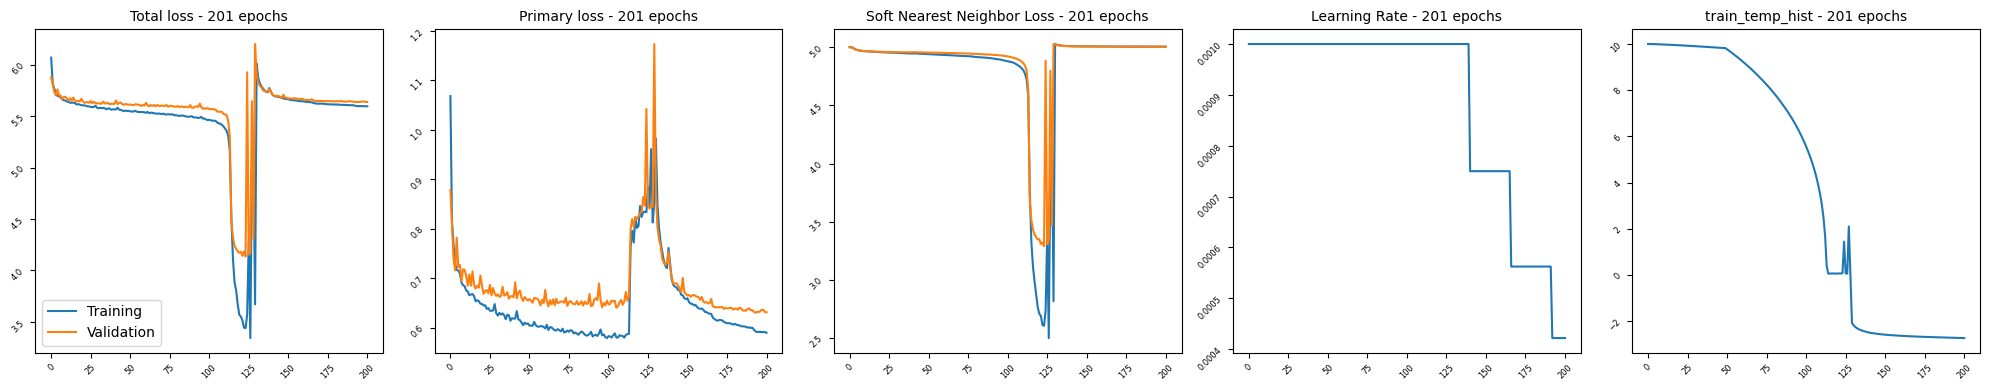

In [63]:
plot_train_history(model, n_bins = 25)

 +------+-------------------------------------------------------+----------------------------------------------+---------------------------------------+
 |      | Weights:                                              |  Biases:                                     |   Gradients:                          |
 | layr |                      min           max         stdev  |             min          max          stdev  |      min          max          stdev  |
 +------+-------------------------------------------------------+----------------------------------------------+---------------------------------------+
 |    0 | (1024, 1471)      -9.130298     5.902162     0.240653 |   1024   -8.981362     7.384085     2.484465 |   -0.001465     0.001397     0.000037 |
 |    1 | (128, 1024)       -0.571613     0.701093     0.053790 |    128   -0.093493     2.000717     0.330298 |   -0.048094     0.044949     0.000744 |
 |    2 | (50, 128)         -0.432118     0.482032     0.117189 |     50   -2.1707

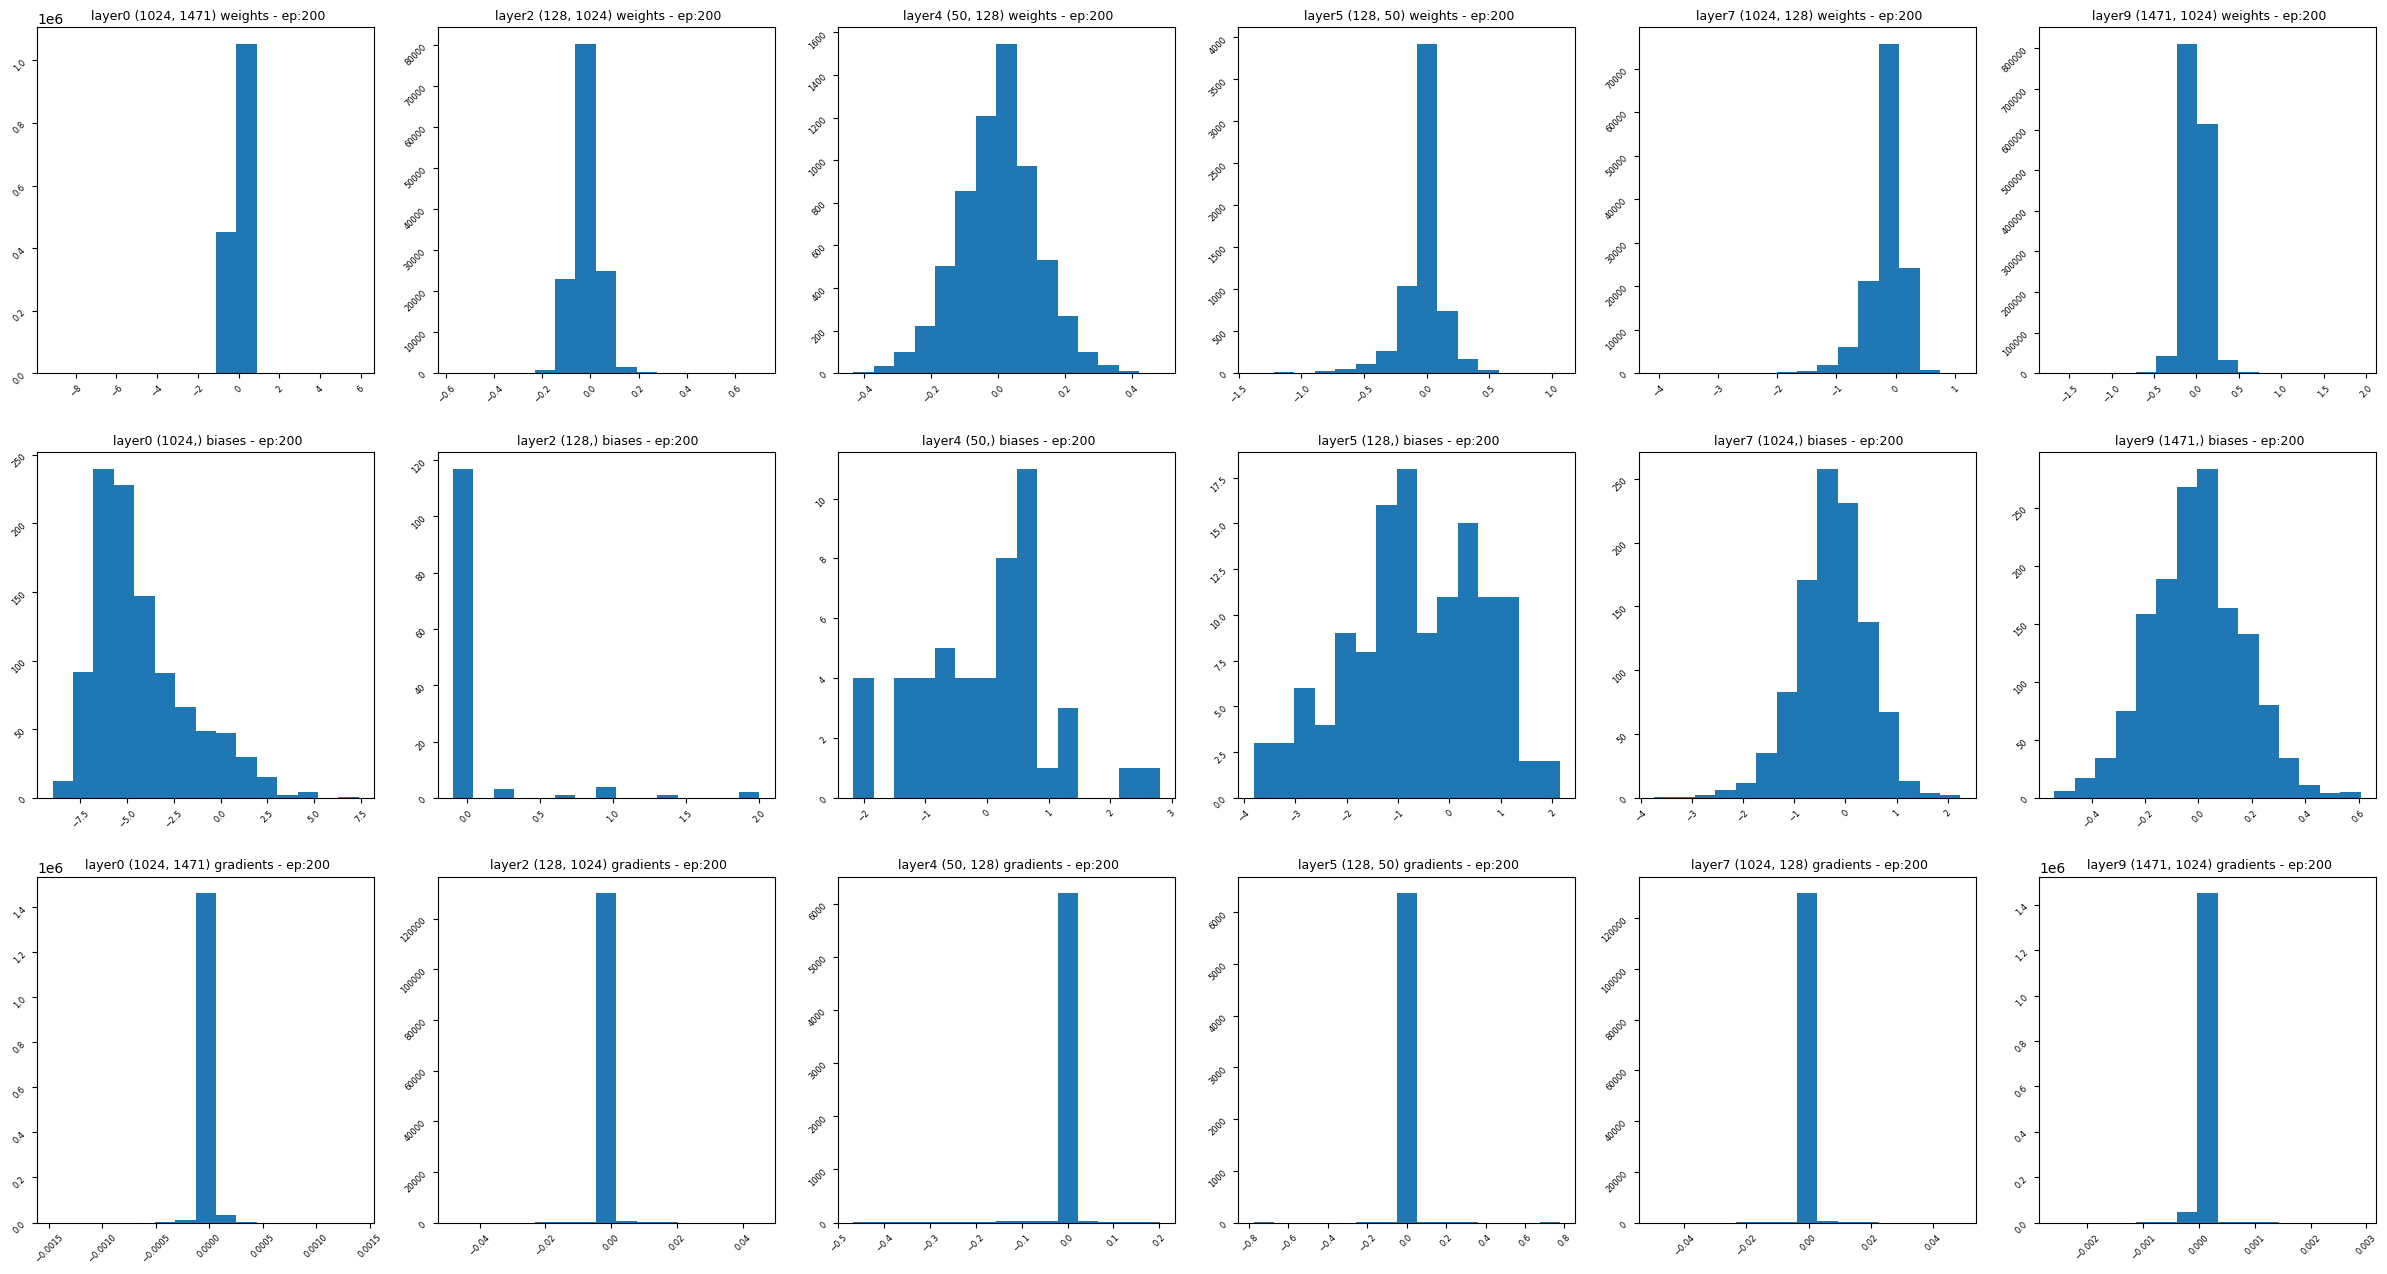

In [66]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

In [ ]:
# plot_train_metrics(model, n_bins = 25)

## Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
export_results(model=model, filename=filename)
save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

## Load model

In [ ]:
# fn = "DNN_snnl_withstatictemp_epoch400_2024_04_01_073006.pt"
# fn = "DNN_snnl_withlearning_temp_epoch250_2024_04_02_173536_model_epoch_250.pth"
# fn = "DNN_snnl_withstatictemp_epoch400_2024_04_01_073006.pt"
# fn = "DNN_snnl_withlearning_temp_epoch250_2024_04_02_173536.json"
# fn = f"DNN_snnl_20240422_temp0grad_{epoch:03d}_cpb_100_factor_{factor:d}.json"
timestamp = "20240502"
factor=1
title="autoencoder"
epoch = 350
filename = f"DNN_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(filename)

In [ ]:
# model, last_epoch = load_checkpoint(model, filename)

# model.eval()
# model = model.cuda(device=current_device)

In [ ]:
last_epoch

In [ ]:
epochs = last_epoch
epoch = last_epoch 
starting_epoch = last_epoch
starting_epoch, epoch , epochs

In [ ]:
# epochs = 40 
# starting_epoch = 20
epochs = epochs + 10
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs}  -- {epoch}")

In [ ]:
loaded_data = import_results(filename)

# for k in loaded_data.keys():
#     print(k, type(loaded_data[k]), len(loaded_data[k]))
# print("\nTraining History")
# results = loaded_data['training_history']
# for k,v in results.items():
#     print(' ',k , len(v))
#     for kk,vv in results[k].items():
#         print( f"   {kk:20s} {len(vv)}")
# print("\nModel Parameters")
# model_parameters = loaded_data['params']
# for k,v in model_parameters.items():
#     print(f"   {k:25s} {v}" )
 

In [ ]:
# model_attributes = model.__dict__
# from collections import defaultdict
# output = defaultdict(dict)

# for key, value in model_attributes.items():
#         if key[0] == "_" or type(value) in [torch.device, torch.optim.Adam , torch.optim.SGD]:
#             continue
#         if key == 'training_history':
#             output[key] = value
#         else:
#             output['params'][key] = value
#             print(f" {key:30s}    {type(value)}   ")

# output.keys()
# output['params']
# output['training_history'].keys()

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
#     model.__dict__[k] = results[k]

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )